### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

XGBoost: XGBoost is an optimized gradient boosting library that uses a combination of boosting and regularized trees to improve model performance. It has gained popularity due to its speed, accuracy, and the ability to handle complex feature interactions.


In [1]:
import pandas as pd
import pickle

# Load the pickle file containing the DataFrame
with open('train_Data.pkl', 'rb') as trf:
    train_Data = pickle.load(trf)

In [2]:
with open('test_Data.pkl', 'rb') as trf:
    test_Data = pickle.load(trf)

In [3]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

In [4]:
X = train_Data.drop(['isFraud'], axis=1)
y = train_Data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [5]:
xgb = XGBClassifier()

In [6]:
%time xgb.fit(X_train, y_train)

CPU times: user 2min 34s, sys: 69.1 ms, total: 2min 34s
Wall time: 53.7 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:
gc.collect()

37

In [8]:
y_pred = xgb.predict(X_test)

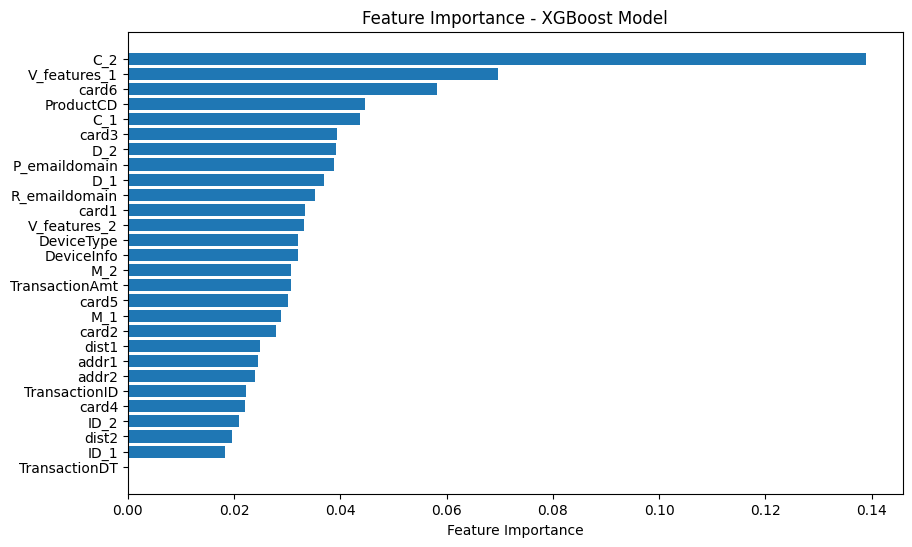

In [17]:
feature_importance = xgb.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort the features and their importance scores
sorted_idx = np.argsort(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - XGBoost Model')
plt.show()

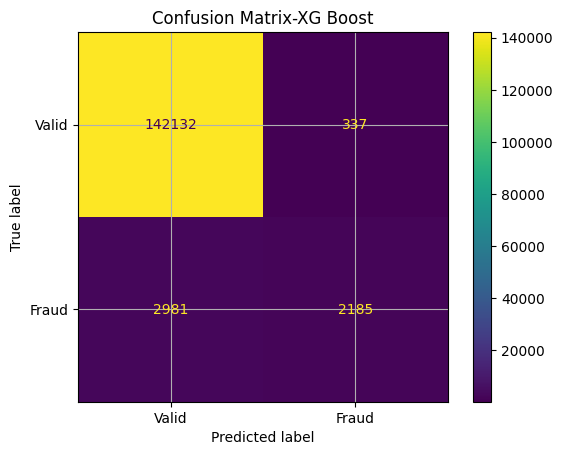

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    142469
         1.0       0.87      0.42      0.57      5166

    accuracy                           0.98    147635
   macro avg       0.92      0.71      0.78    147635
weighted avg       0.98      0.98      0.97    147635



In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix using ConfusionMatrixDisplay
dispp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Valid', 'Fraud'])
dispp.plot()
plt.title("Confusion Matrix-XG Boost")
plt.grid(None)
plt.show()
print(classification_report(y_test, y_pred, zero_division=0))

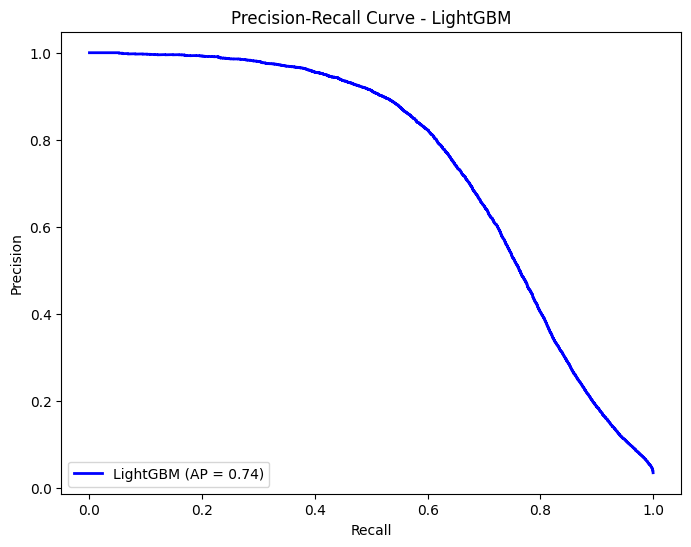

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Step 1: Train the LightGBM classifier on the training data
xgb.fit(X_train, y_train)

# Step 2: Predict the anomaly scores (probability of positive class) on the training data
anomaly_scores_train = xgb.predict_proba(X_train)[:, 1]

# Step 3: Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_train, anomaly_scores_train)

# Step 4: Calculate average precision score
average_precision = average_precision_score(y_train, anomaly_scores_train)

# Step 5: Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f"LightGBM (AP = {average_precision:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LightGBM')
plt.legend(loc="lower left")
plt.show()


In [11]:
print('Test ROC AUC score:', roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))
print('Train ROC AUC score:', roc_auc_score(y_train, xgb.predict_proba(X_train)[:, 1]))

Test ROC AUC score: 0.9284581804970066
Train ROC AUC score: 0.9555663983933178


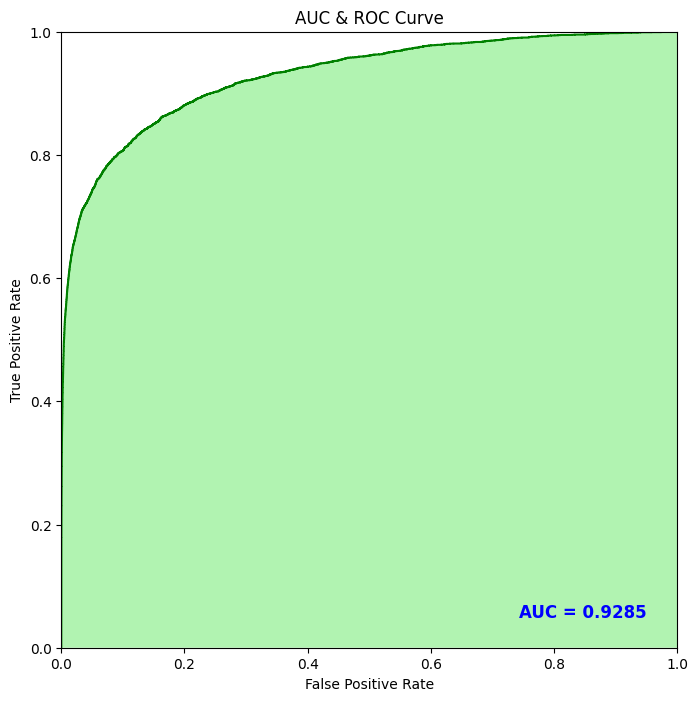

In [12]:
from sklearn import metrics

y_pred = xgb.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [13]:
subb= pd.read_csv(r'sample_submission1.csv')

In [14]:
subb['isFraud']=pd.DataFrame(xgb.predict_proba(test_Data))[[1]]

In [15]:
subb.to_csv('./submissionXG.csv',index=False)

In [16]:
subb.head()

,TransactionID,isFraud
0,3663549,0.005000
1,3663550,0.004200
2,3663551,0.030942
3,3663552,0.014838
4,3663553,0.012947
